In [34]:
import sys
sys.path.append("./../../src")
from visualizer_helper import Visualizer

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.sparse import csr_matrix
import scipy
import pickle
import os
from annoy import AnnoyIndex
from scipy.sparse.linalg import inv
from collections import Counter

In [4]:
k_neighbors = 2000
evecs=50

In [6]:
A = pickle.load(open("./../../../large_data_files/A_mknn_K{}_CSR.p".format(k_neighbors), "rb"))

D = pickle.load(open("./data/D_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
D_mc = pickle.load(open("./data/D_mc_mknn_K{}_CSR.p".format(k_neighbors), "rb"))

# D_inv_sqrt = pickle.load(open("./data/D_mknn_inv_sqrt_K{}_CSR.p".format(k_neighbors), "rb"))
# D_mc_inv_sqrt = pickle.load(open("./data/D_mc_mknn_inv_sqrt_K{}_CSR.p".format(k_neighbors), "rb"))

L = pickle.load(open("./data/L_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
L_mc = pickle.load(open("./data/L_mc_mknn_K{}_CSR.p".format(k_neighbors), "rb"))

L_evals = pickle.load(open("./data/L_evals{}_K{}.p".format(evecs, k_neighbors), "rb"))
L_evecs = pickle.load(open("./data/L_evecs{}_K{}.p".format(evecs, k_neighbors), 'rb'))

L_mc_evals = pickle.load(open("./data/L_mc_evals{}_K{}.p".format(evecs, k_neighbors), "rb"))
L_mc_evecs = pickle.load(open("./data/L_mc_evecs{}_K{}.p".format(evecs, k_neighbors), "rb"))

[ 1.          0.9998497   0.92732817  0.90785311  0.88933743  0.88095456
  0.83915946  0.81860116  0.73231867  0.7093878   0.70231609  0.66675754
  0.65023243  0.64293373  0.63889631  0.61387624  0.58075589  0.55546652
  0.53704593  0.53557277  0.53543944  0.52001813  0.51959169  0.50576573
  0.50091899  0.49921913  0.49427005  0.48824308  0.48168461  0.47177675
  0.47002137  0.46102819  0.45478353  0.44372971  0.44049755  0.43361993
  0.43157127  0.42477834  0.42081767  0.41602439  0.41398782  0.40992295
  0.4080404   0.40281182  0.40081328  0.39635621  0.39028869  0.38961744
  0.38405645 -0.39889951]
[0.79820765 0.64909943 0.63671329 0.56314511 0.48794017 0.47916282
 0.43378738 0.40331573 0.36953029 0.35545269 0.34999924 0.34542617
 0.32396076 0.29316968 0.28765595 0.27906199 0.27001638 0.26933342
 0.2584566  0.25602508 0.25155018 0.24753878 0.24521216 0.23847034
 0.23310536 0.22257145 0.2171287  0.21144081 0.20893018 0.20349509
 0.20256252 0.19871733 0.19256251 0.1900283  0.18881095

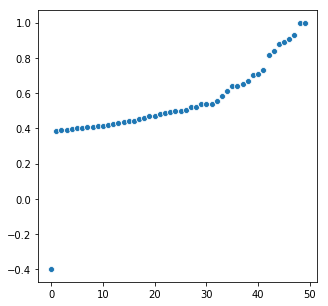

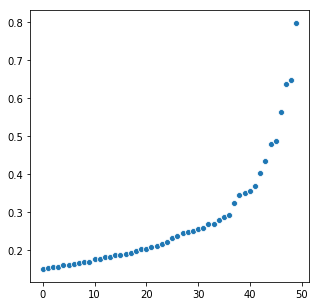

In [7]:
print(np.flip(L_evals))
plt.figure(figsize=(5,5))
ax = sns.scatterplot(range(L_evals.shape[0]), L_evals)

print(np.flip(L_mc_evals))
plt.figure(figsize=(5,5))
ax = sns.scatterplot(range(L_evals.shape[0]), L_mc_evals)

In [8]:
def get_evec_df(evecs, top_k_evecs=5):
    k_evecs = evecs[:, -top_k_evecs:]
    evec_cols = ["Evec_{}".format(i) for i in range(top_k_evecs)]
    evec_df = pd.DataFrame(k_evecs, columns=evec_cols)
    return evec_df

L_evecdf = get_evec_df(L_evecs, top_k_evecs=10)
L_mc_evecdf = get_evec_df(L_mc_evecs, top_k_evecs=10)

In [9]:
print(L_evecdf.describe())
print(L_mc_evecdf.describe())

             Evec_0        Evec_1        Evec_2        Evec_3        Evec_4  \
count  4.518200e+04  45182.000000  45182.000000  45182.000000  4.518200e+04   
mean  -5.046557e-05      0.000320      0.000289      0.000187 -2.017690e-05   
std    4.704323e-03      0.004694      0.004696      0.004701  4.704550e-03   
min   -4.036980e-02     -0.026853     -0.007184     -0.013992 -9.999075e-01   
25%   -2.875287e-06     -0.000839     -0.002786     -0.002194 -5.013838e-07   
50%    1.987895e-07      0.000230     -0.001115      0.000034  4.138964e-06   
75%    2.612884e-06      0.002345      0.000860      0.002427  8.127569e-06   
max    5.092547e-02      0.019345      0.026834      0.017834  3.291490e-05   

             Evec_5        Evec_6        Evec_7        Evec_8        Evec_9  
count  45182.000000  45182.000000  45182.000000  45182.000000  45182.000000  
mean       0.000436     -0.000054      0.001142      0.000974      0.004215  
std        0.004684      0.004704      0.004564      0

In [10]:
def get_Y(evecs, drop_k_evecs = 1, keep_top_k_evecs = 5):
    X_top_k = evecs[:, -drop_k_evecs-keep_top_k_evecs:-drop_k_evecs]
    evecs_lengths_top_k = np.linalg.norm(X_top_k, axis=1)
    Y_top_k = X_top_k / evecs_lengths_top_k[:, None]
    return Y_top_k

keep_k_evecs=8
drop_k_evecs=2
Y = get_Y(L_evecs, drop_k_evecs=drop_k_evecs, keep_top_k_evecs=keep_k_evecs)
Y_mc = get_Y(L_mc_evecs, drop_k_evecs=drop_k_evecs, keep_top_k_evecs=keep_k_evecs)

print(Y.shape, Y_mc.shape)

(45182, 8) (45182, 8)


In [11]:
visualizer = Visualizer()
lc=100

try:
    Y_umap_2d = pickle.load(open("./data/Y_umap_2d_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))
    Y_umap_3d = pickle.load(open("./data/Y_umap_3d_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))

    Y_mc_umap_2d = pickle.load(open("./data/Y_umap_2d_mc_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))
    Y_mc_umap_3d = pickle.load(open("./data/Y_umap_3d_mc_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))
except FileNotFoundError:
    print("Error: 1 or more umap files not found")
    Y_umap_2d = visualizer.umap_embedding(Y, n_components=2, lc=lc)
    Y_umap_3d = visualizer.umap_embedding(Y, n_components=3, lc=lc)
    
    Y_mc_umap_2d = visualizer.umap_embedding(Y_mc, n_components=2, lc=lc)
    Y_mc_umap_3d = visualizer.umap_embedding(Y_mc, n_components=3, lc=lc)

    pickle.dump(Y_umap_2d, open("./data/Y_umap_2d_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'wb'))
    pickle.dump(Y_umap_3d, open("./data/Y_umap_3d_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'wb'))

    pickle.dump(Y_mc_umap_2d, open("./data/Y_umap_2d_mc_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'wb'))
    pickle.dump(Y_mc_umap_3d, open("./data/Y_umap_3d_mc_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'wb'))

Error: 1 or more umap files not found


./../../src/visualizer_helper.py:22: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  return UMAP(n_components=n_components, local_connectivity=lc).fit_transform(X)
./../../src/visualizer_helper.py:22: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  return UMAP(n_components=n_components, local_connectivity=lc).fit_transform(X)


running Kmeans
Cluster labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


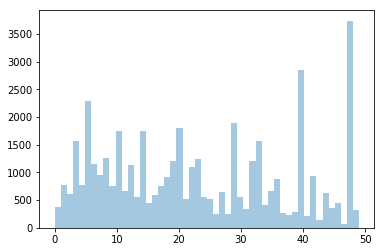

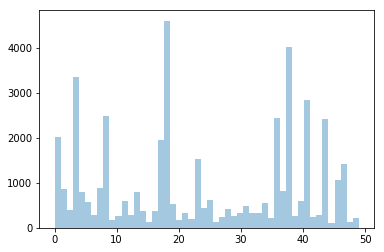

In [12]:
knn_clusters = 50

try:
    Y_cluster_labels = pickle.load(open("./data/cluster_labels_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), 'rb'))
    Y_mc_cluster_labels = pickle.load(open("./data/cluster_labels_mc_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), 'rb'))
except FileNotFoundError:
    print("running Kmeans")
    
    Y_kmeans = KMeans(n_clusters=knn_clusters).fit(Y)
    Y_mc_kmeans = KMeans(n_clusters=knn_clusters).fit(Y_mc)

    Y_cluster_labels = Y_kmeans.labels_    
    Y_mc_cluster_labels = Y_mc_kmeans.labels_

    pickle.dump(Y_cluster_labels, open("./data/cluster_labels_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), "wb"))
    pickle.dump(Y_mc_cluster_labels, open("./data/cluster_labels_mc_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), "wb"))

    print("Cluster labels:", np.unique(Y_cluster_labels))
    
plt.figure()
sns.distplot(Y_cluster_labels, bins=knn_clusters, kde=False)
plt.figure()
sns.distplot(Y_mc_cluster_labels, bins=knn_clusters, kde=False)

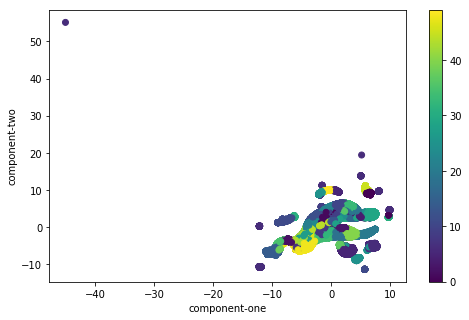

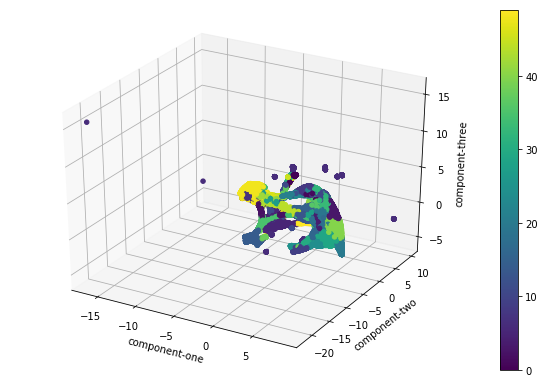

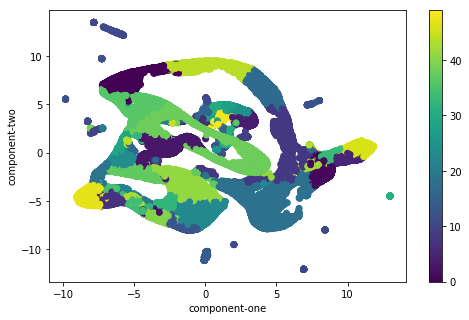

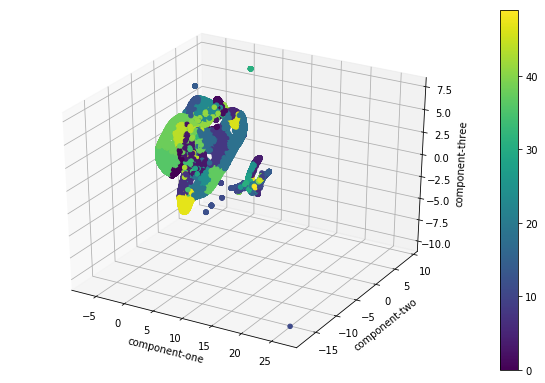

In [13]:
alpha = 1

filename_2d = "./figures/umap2d_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)
filename_3d = "./figures/umap3d_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)   

filename_mc_2d = "./figures/umap2d_mc_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)
filename_mc_3d = "./figures/umap3d_mc_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)

visualizer.plot2d(
    X=Y_umap_2d, 
    filename=filename_2d, 
    colors=Y_cluster_labels,
    alpha = alpha
)

visualizer.plot3d(
    X=Y_umap_3d, 
    filename=filename_3d, 
    colors=Y_cluster_labels,
    alpha = alpha
)

visualizer.plot2d(
    X=Y_mc_umap_2d, 
    filename=filename_mc_2d, 
    colors=Y_mc_cluster_labels,
    alpha = alpha
)
visualizer.plot3d(
    X=Y_mc_umap_3d, 
    filename=filename_mc_3d, 
    colors=Y_mc_cluster_labels,
    alpha = alpha
)

In [42]:
def sort_by_cluster_membership(M, cluster_labels):
    sorted_cluster_labels = sorted(list(enumerate(cluster_labels.tolist())), key=lambda p: p[1])
    clusters_by_idx = [p[0] for p in sorted_cluster_labels]
    return M[clusters_by_idx][:, clusters_by_idx]

def sort_by_top_k_cluster_membership(M, k, cluster_labels):    
    most_common_clusters = [c[0] for c in Counter(cluster_labels).most_common(k)]
    print(Counter(cluster_labels).most_common(k))
    
    sorted_cluster_labels = sorted(list(enumerate(cluster_labels.tolist())), key=lambda p: p[1])
    
    sorted_cluster_labels_filtered = [p for p in sorted_cluster_labels if p[1] in most_common_clusters]
    clusters_by_idx = [p[0] for p in sorted_cluster_labels_filtered]
    return M[clusters_by_idx][:, clusters_by_idx]
    
L_sorted = sort_by_cluster_membership(L, Y_cluster_labels)
L_mc_sorted = sort_by_cluster_membership(L_mc, Y_mc_cluster_labels)

A_sorted = sort_by_cluster_membership(A, Y_cluster_labels)
A_mc_sorted = sort_by_cluster_membership(A, Y_mc_cluster_labels)

topk_clusters = 4
L_sorted_topk = sort_by_top_k_cluster_membership(L, topk_clusters, Y_cluster_labels)
L_mc_sorted_topk = sort_by_top_k_cluster_membership(L_mc, topk_clusters, Y_mc_cluster_labels)

A_sorted_topk = sort_by_top_k_cluster_membership(A, topk_clusters, Y_cluster_labels)
A_mc_sorted_topk = sort_by_top_k_cluster_membership(A, topk_clusters, Y_mc_cluster_labels)

print(L_sorted.shape, A_sorted.shape, L_mc_sorted.shape, A_mc_sorted.shape)
print(L_sorted_topk.shape, L_mc_sorted_topk.shape, A_sorted_topk.shape, A_mc_sorted_topk.shape)

[(48, 3741), (40, 2852), (5, 2295), (29, 1886)]
[(18, 4606), (38, 4019), (3, 3353), (41, 2842)]
[(48, 3741), (40, 2852), (5, 2295), (29, 1886)]
[(18, 4606), (38, 4019), (3, 3353), (41, 2842)]
(45182, 45182) (45182, 45182) (45182, 45182) (45182, 45182)
(10774, 10774) (14820, 14820) (10774, 10774) (14820, 14820)


In [ ]:
##Full Heatmaps
plot_vars = [A_sorted_topk, A_mc_sorted_topk, L_sorted_topk, L_mc_sorted_topk]
plot_var_names = ['A_sorted_topk', 'A_mc_sorted_topk', 'L_sorted_topk', 'L_mc_sorted_topk']
for v in range(len(plot_vars)):
    var = plot_vars[v]
    varname = plot_var_names[v]

    plotmax = var.log1p().log1p().max()/2.0
    plt.figure(figsize=(20,16))
    sns.heatmap(var.log1p().log1p().toarray(), cmap="Reds", vmax=plotmax)
    plt.savefig("./figures/heatmap_{}_K{}_knn{}_kevecs{}.png".format(varname, k_neighbors, knn_clusters, keep_k_evecs))

0 1000
1000 2000
2000 3000
3000 4000
4000 5000
5000 6000
6000 7000
7000 8000
8000 9000
9000 10000
10000 11000
11000 12000
12000 13000
13000 14000
14000 15000
15000 16000
16000 17000
17000 18000
18000 19000
19000 20000
20000 21000
21000 22000
22000 23000
23000 24000
24000 25000
25000 26000
26000 27000
27000 28000
28000 29000
29000 30000
30000 31000
31000 32000
32000 33000
33000 34000
34000 35000


KeyboardInterrupt: 

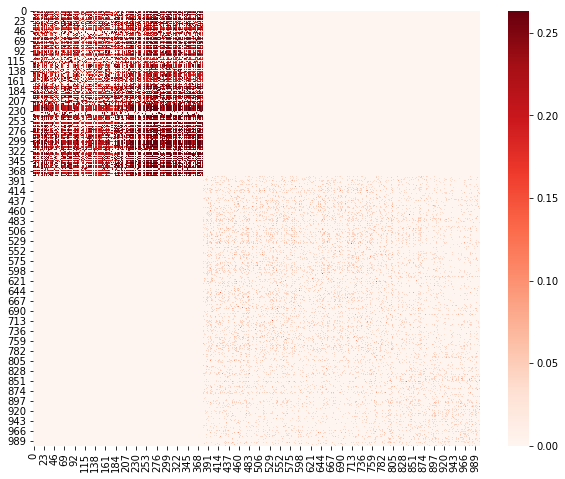

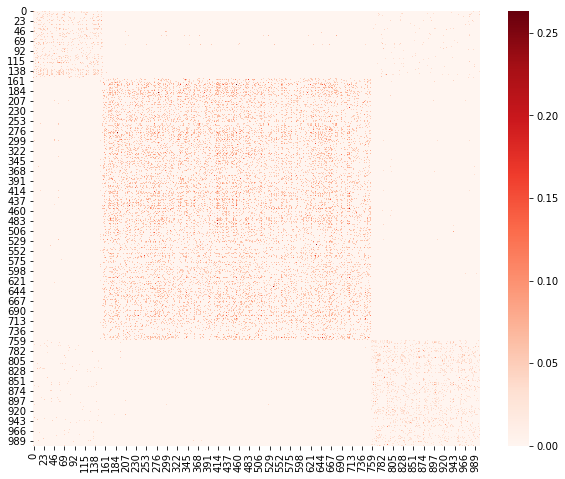

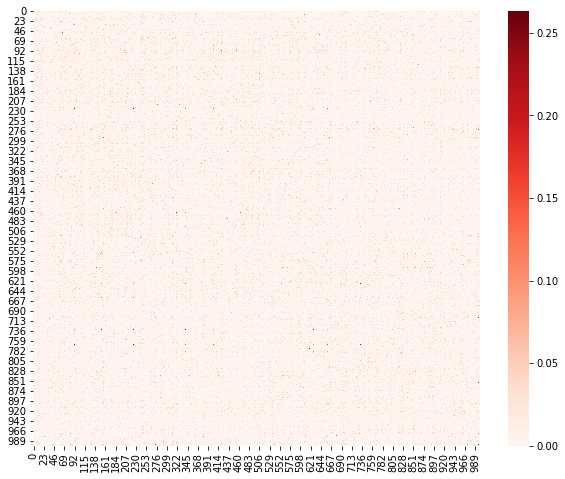

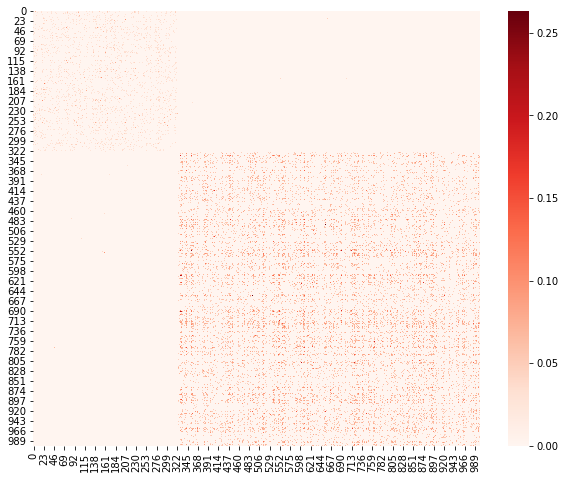

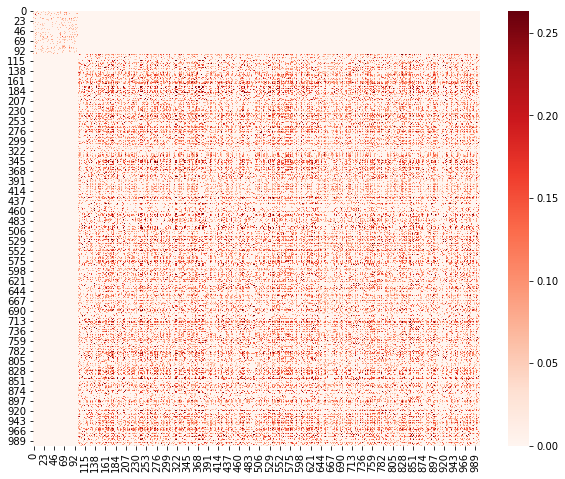

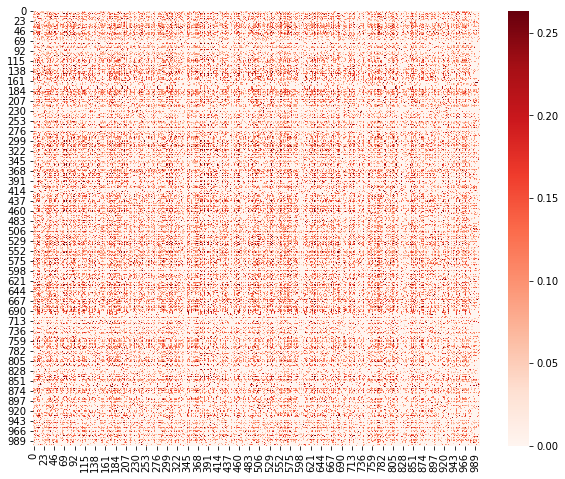

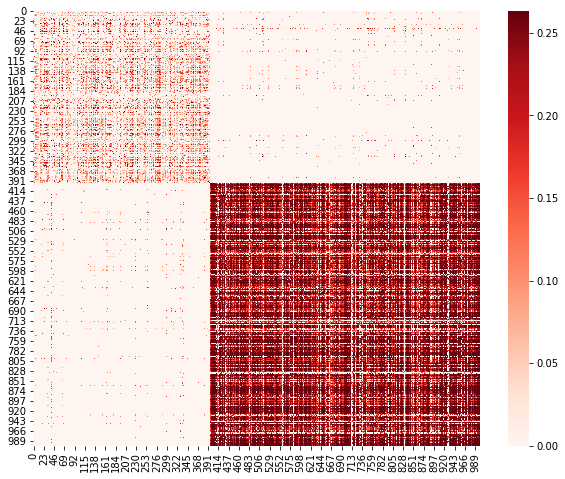

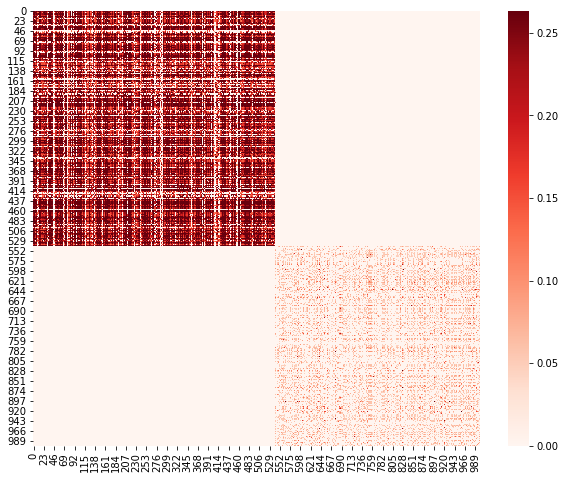

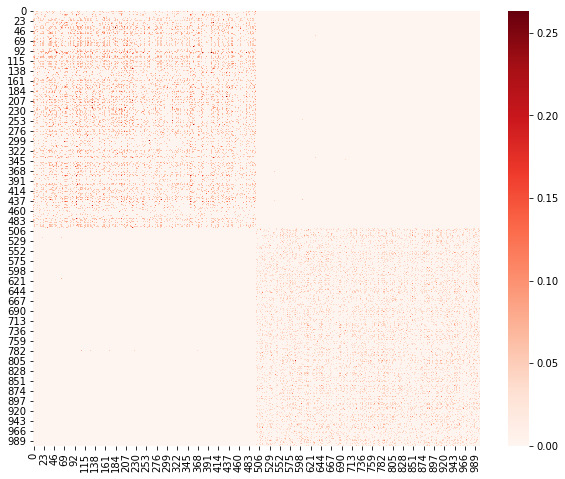

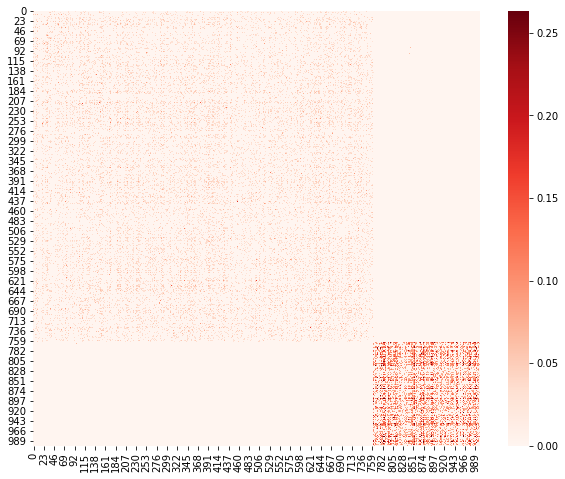

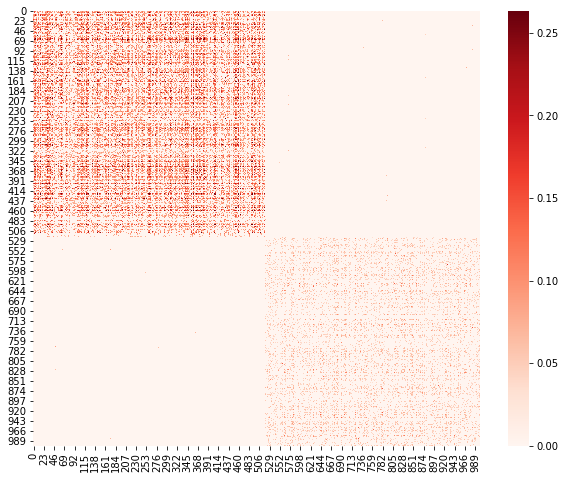

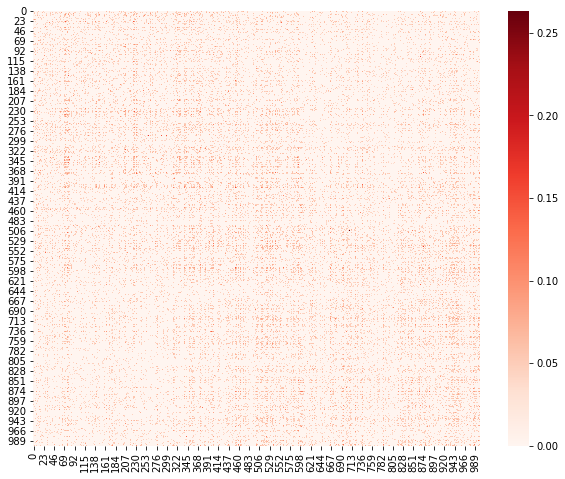

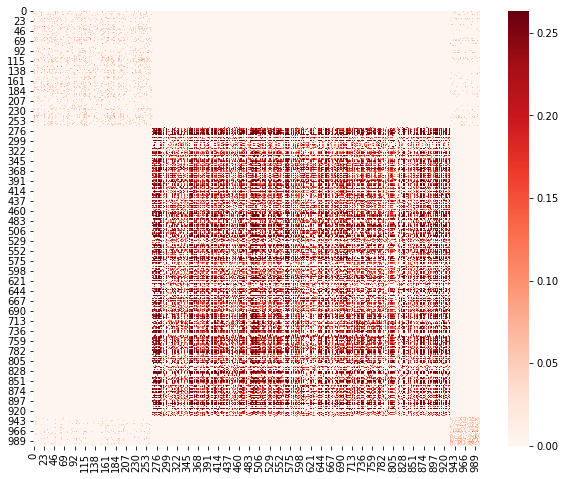

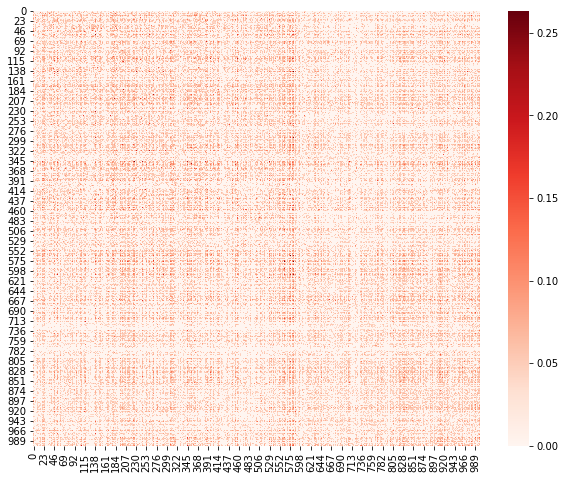

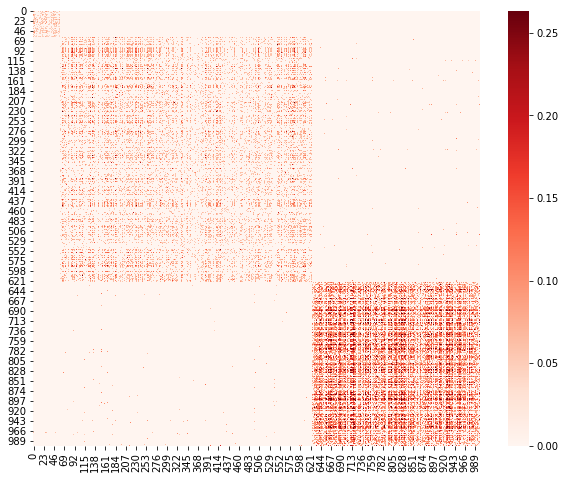

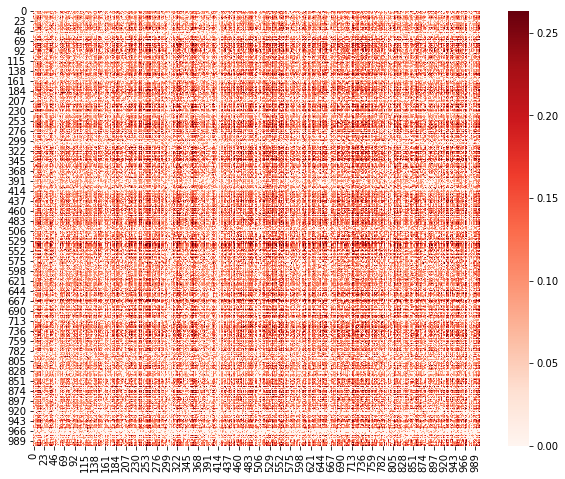

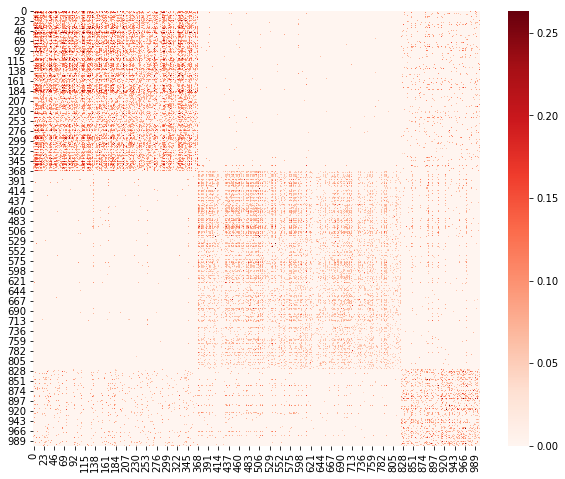

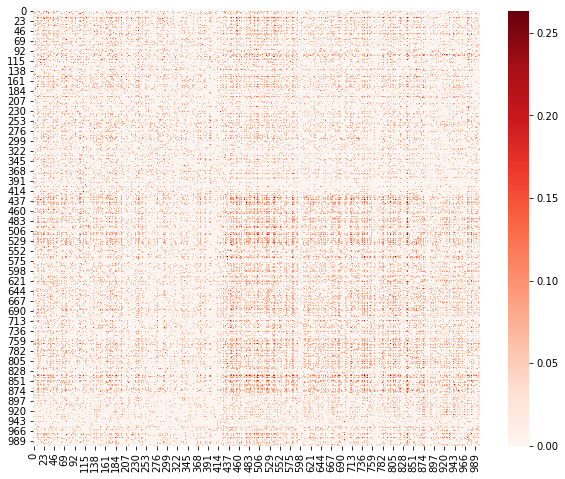

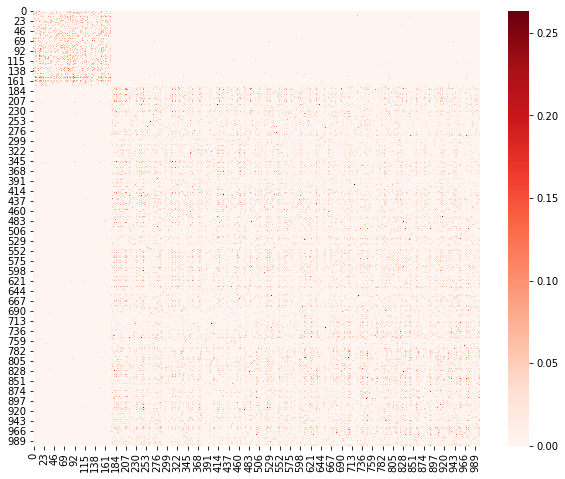

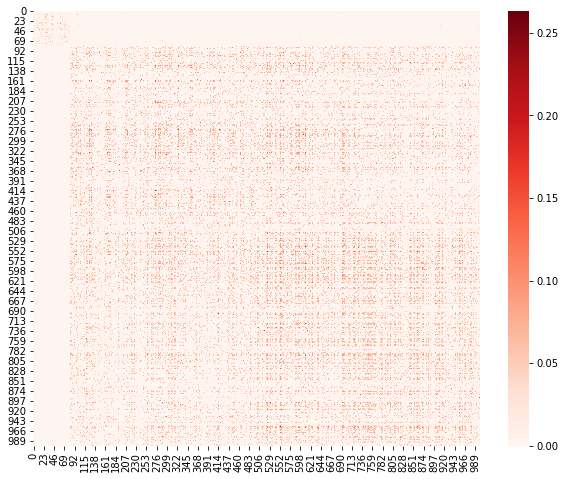

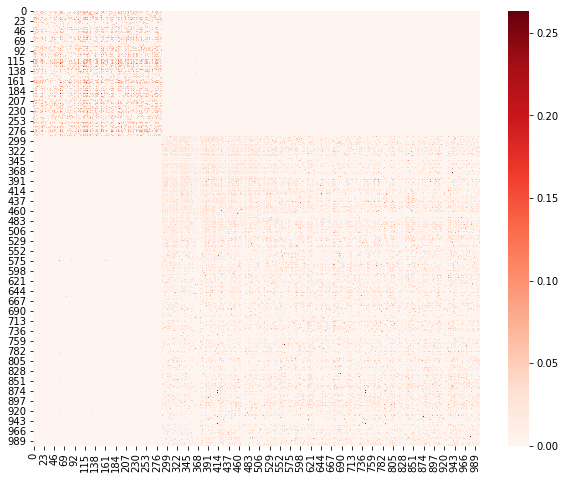

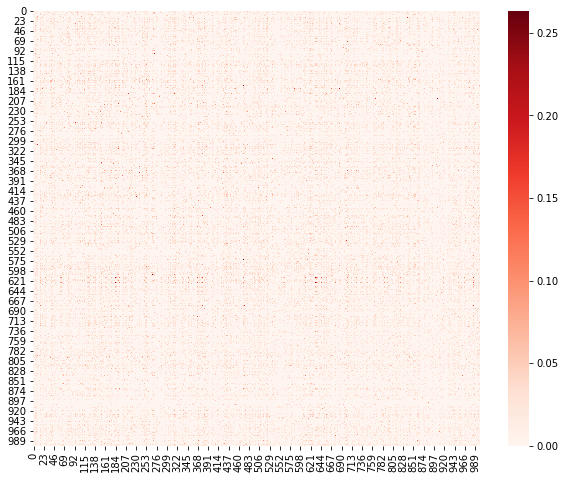

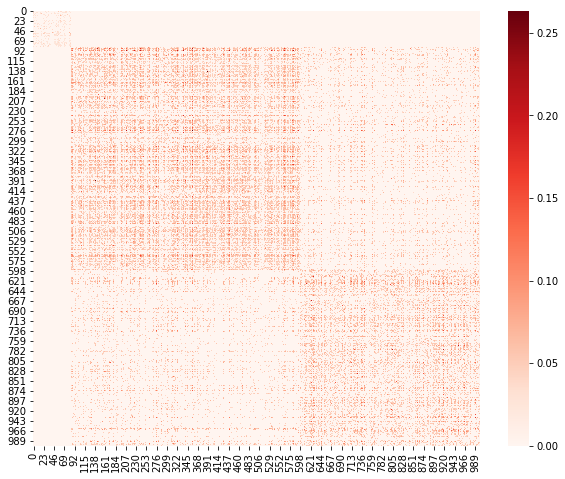

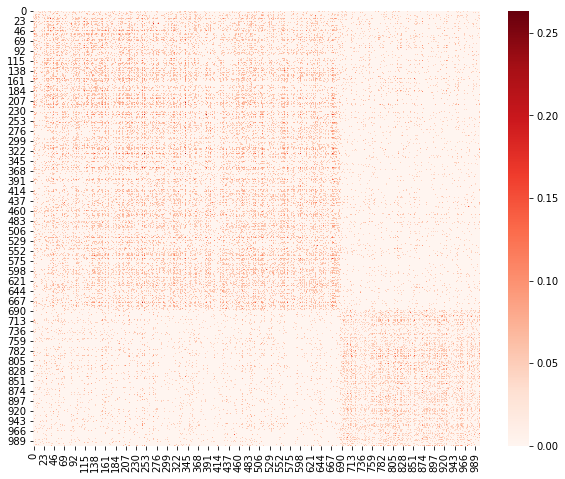

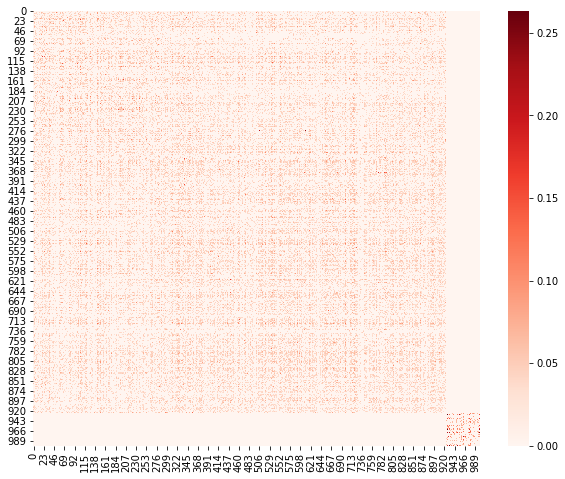

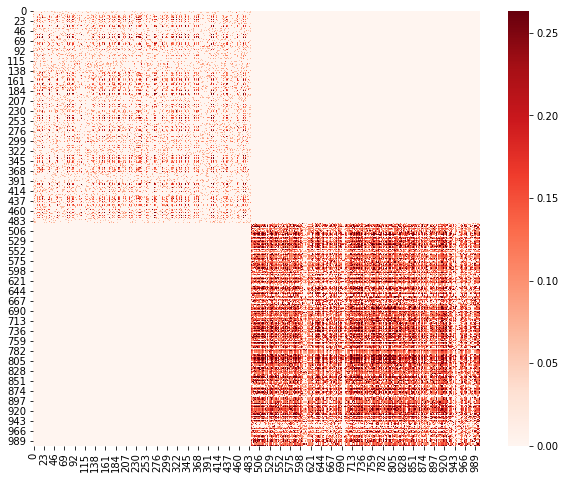

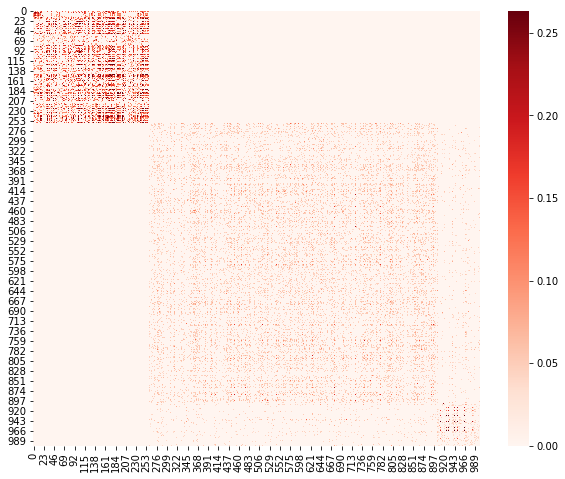

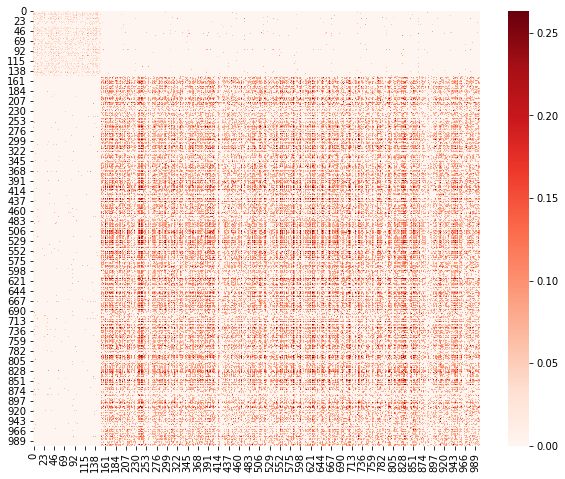

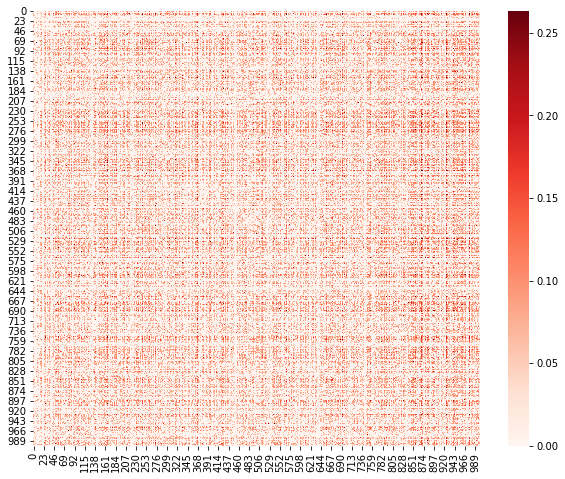

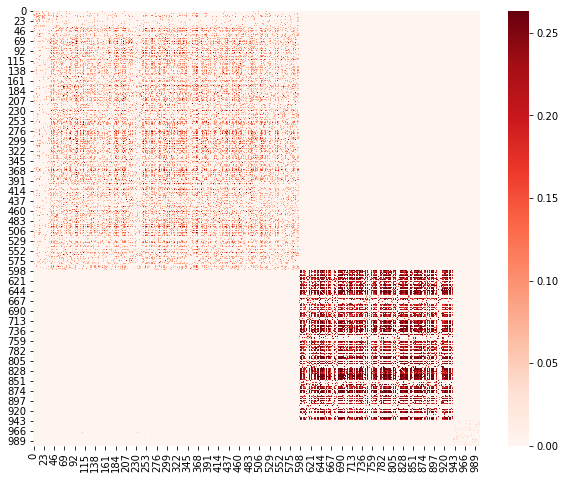

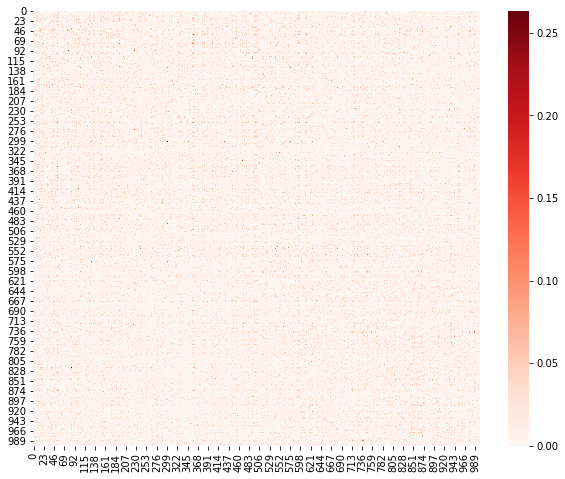

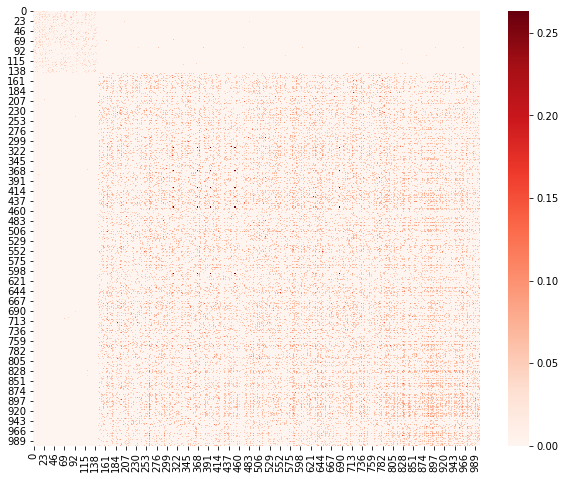

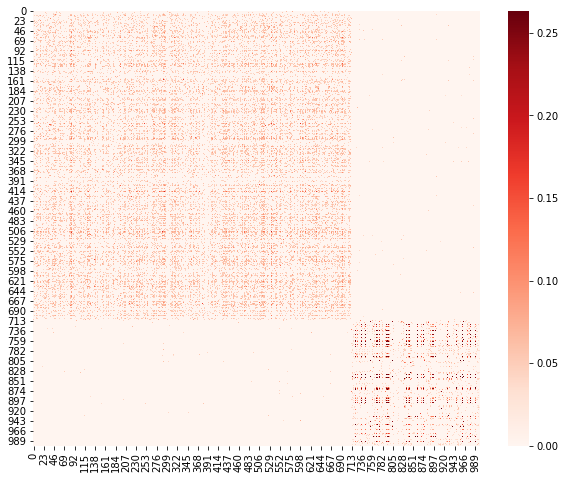

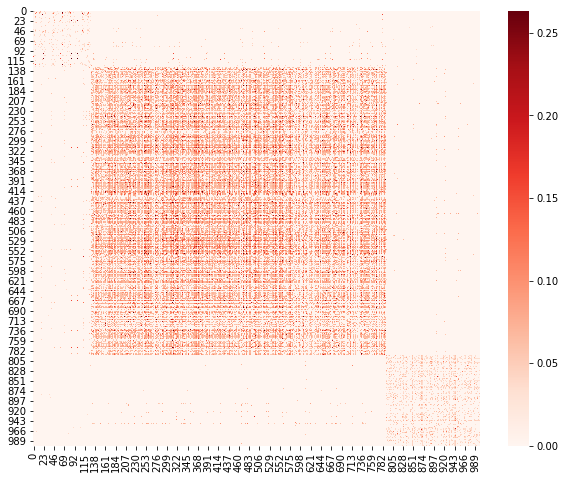

In [33]:
plotmax = var.log1p().log1p().max()/2.0
plt.figure(figsize=(10,8))
sns.heatmap(var[start:end, start:end].log1p().log1p().toarray(), cmap="Reds", vmax=plotmax)
plt.savefig("./figures/heatmap_{}_K{}_knn{}_kevecs{}_{}thru{}.png".format(varname, k_neighbors, knn_clusters, keep_k_evecs, start, end))